[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ee-ortiz/ISIS-4825_202510_IMAGENES_Y_VISION/blob/main/Laboratorio_06/Practica/MISIS4825_Laboratorio06_Practica.ipynb)

![image](https://drive.google.com/u/0/uc?id=15DUc09hFGqR8qcpYiN1OajRNaASmiL6d&export=download)

# Laboratorio 06 - Práctica: Fundamentos de Machine Learning y Redes Neuronales

## Objetivos

- Explicar conceptos de Machine Learning, haciendo énfasis en el aprendizaje automático y las redes neuronales.
- Profundizar en el uso de TensorFlow y Keras para la construcción y entrenamiento de modelos.
- Implementar una red neuronal simple para clasificación de imágenes utilizando datos preprocesados.

## Contexto

La inteligencia artificial es fundamental en la era actual debido a su capacidad para automatizar tareas complejas, mejorar la toma de decisiones y descubrir patrones ocultos en grandes volúmenes de datos.

En el ámbito del deep learning, se utilizan redes neuronales para aprender representaciones complejas de los datos. Estas redes son capaces de realizar tareas avanzadas como el reconocimiento de imágenes y el procesamiento del lenguaje natural.

Para construir y entrenar modelos de deep learning, podemos utilizar herramientas como TensorFlow y Keras. Keras es una API de alto nivel integrada en TensorFlow que simplifica la creación y entrenamiento de modelos de redes neuronales, permitiendo trabajar de manera ágil con capas, activadores y optimizadores.

## Datos:

[5 Flower Types Classification Dataset](https://www.kaggle.com/datasets/kausthubkannan/5-flower-types-classification-dataset)


## 1. Importación de Librerías

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import cv2
import json

## 2. Descarga y Preparación del Dataset

Se utiliza la API de Kaggle para descargar el dataset de clasificación de flores. Se requiere disponer del archivo `kaggle.json` con las credenciales de la API.

In [2]:
# Instalación de Kaggle
!pip install kaggle --quiet

In [3]:
# Cargar credenciales desde 'kaggle.json'
with open('./kaggle.json') as f:
    kaggle_credentials = json.load(f)

os.environ['KAGGLE_USERNAME'] = kaggle_credentials['username']
os.environ['KAGGLE_KEY'] = kaggle_credentials['key']

# Autenticación y descarga del dataset
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()
api.dataset_download_files('kausthubkannan/5-flower-types-classification-dataset', path='data', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/kausthubkannan/5-flower-types-classification-dataset


## 3. Exploración de Imágenes

El objetivo de esta sección es observar la calidad y diversidad de las imágenes que se utilizarán en el modelo.

**Nota:** En un experimento adicional, se podrían aplicar técnicas de procesamiento como la ecualización y filtros para mejorar el contraste y realzar detalles.

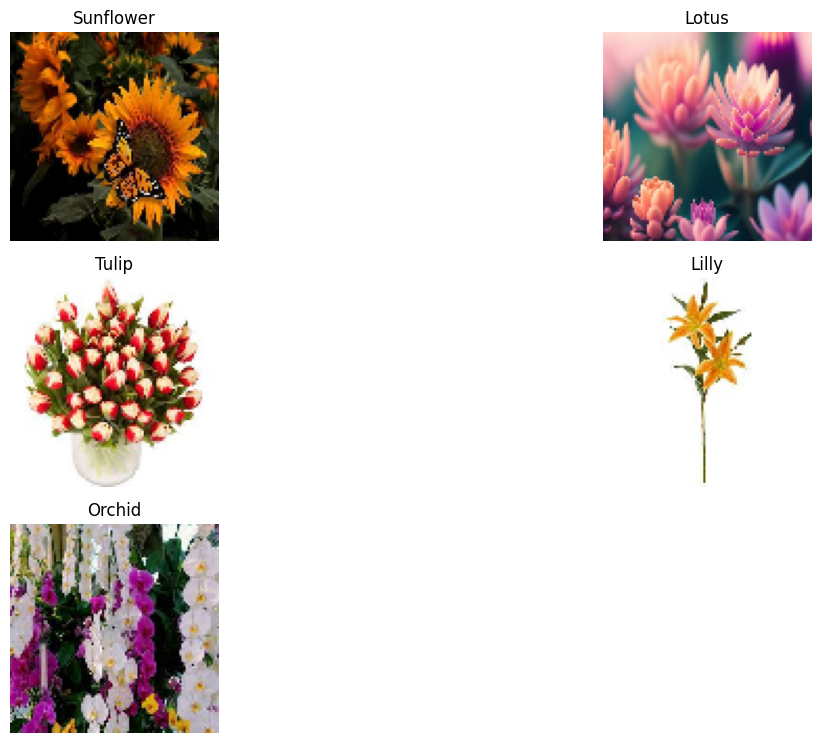

In [4]:
# Directorio de imágenes y categorías
data_dir = 'data/flower_images'
flower_categories = os.listdir(data_dir)

# Visualización de imágenes originales
plt.figure(figsize=(12, 10))
for i, category in enumerate(flower_categories):
    folder = os.path.join(data_dir, category)
    image_file = os.listdir(folder)[0]
    img_path = os.path.join(folder, image_file)

    # Cargar imagen original
    img = keras.preprocessing.image.load_img(img_path, target_size=(100, 100))
    img_array = keras.preprocessing.image.img_to_array(img) / 255.0

    plt.subplot(4, 2, i+1)
    plt.imshow(img_array)
    plt.title(category)
    plt.axis('off')
plt.tight_layout()
plt.show()


## 4. Preparación de Datos y División en Entrenamiento, Validación y Test

Se generan listas con las rutas de las imágenes y sus etiquetas (la categoría se infiere del nombre de la carpeta).  
Posteriormente se divide el conjunto de datos en entrenamiento (70%), validación (20%) y test (10%).

In [5]:
# Recopilación de rutas y etiquetas
filepaths = [os.path.join(dp, f) for dp, dn, filenames in os.walk(data_dir)
             for f in filenames if os.path.splitext(f)[1].lower() in ['.png','.jpg','.jpeg']]
labels = [os.path.split(os.path.split(path)[0])[1] for path in filepaths]

# Crear un DataFrame con rutas y etiquetas
data_df = pd.DataFrame({'filepath': filepaths, 'label': labels})

# División de datos: 70% entrenamiento, 30% para validación y test (10% test, 20% validación)
from sklearn.model_selection import train_test_split
train_df, test_val_df = train_test_split(data_df, test_size=0.3, random_state=42)
test_df, val_df = train_test_split(test_val_df, test_size=2/3, random_state=42)

print("Total de imágenes:", len(data_df))
print("Entrenamiento:", len(train_df))
print("Validación:", len(val_df))
print("Test:", len(test_df))

Total de imágenes: 4999
Entrenamiento: 3499
Validación: 1000
Test: 500


## 5. Procesamiento y Generadores de Imágenes

Se utiliza `ImageDataGenerator` de Keras para generar batches de datos. El preprocesamiento definido se aplica "on the fly" (a medida que los datos se están utilizando) a las imágenes.

En este caso, se reescala la imagen a [0,1]. Además, se incluye data augmentation en el conjunto de entrenamiento para mejorar la robustez del modelo.

In [6]:
# Generador para el conjunto de entrenamiento con data augmentation
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True
)

# Generador para validación y test (solo reescala)
test_val_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

# Crear los generadores a partir de los DataFrames
train_gen = train_datagen.flow_from_dataframe(
    train_df, x_col='filepath', y_col='label',
    target_size=(100, 100), batch_size=32
)
val_gen = test_val_datagen.flow_from_dataframe(
    val_df, x_col='filepath', y_col='label',
    target_size=(100, 100), batch_size=32, shuffle=False
)
test_gen = test_val_datagen.flow_from_dataframe(
    test_df, x_col='filepath', y_col='label',
    target_size=(100, 100), batch_size=32, shuffle=False
)

Found 3499 validated image filenames belonging to 5 classes.
Found 1000 validated image filenames belonging to 5 classes.
Found 500 validated image filenames belonging to 5 classes.


## 6. Construcción y Compilación del Modelo

Se construye una red neuronal simple para la clasificación de imágenes utilizando Keras.  
La arquitectura incluye:
- Una capa de flatten para convertir la imagen en un vector.
- Dos capas densas con activación ReLU.
- Una capa de dropout para regularizar y prevenir el sobreajuste.
- Una capa final con activación softmax para la clasificación.

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout

model = Sequential([
    Flatten(input_shape=(100, 100, 3)),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dense(len(flower_categories), activation='softmax')
])

# Resumen del modelo y su arquitectura
model.summary()

# Compilar el modelo
model.compile(optimizer='adam', # Determina cómo se actualizan los pesos de la red durante el entrenamiento
              loss='categorical_crossentropy', # Mide qué tan bien el modelo está haciendo predicciones
              metrics=['accuracy']) # Monitorear el rendimiento del modelo durante el entrenamiento y la prueba


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 30000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      15,360,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,493,125 (59.10 MB)

 Trainable params: 15,493,125 (59.10 MB)

 Non-trainable params: 0 (0.00 B)

## 7. Entrenamiento del Modelo

El modelo se entrena utilizando el conjunto de entrenamiento y se valida con el de validación.  
Se incluyen callbacks para:
- Guardar el mejor modelo.
- Detener el entrenamiento de manera temprana si la métrica de validación no mejora.
- Ajustar la tasa de aprendizaje si es necesario.

In [8]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True,
                                   monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='min')

callbacks = [model_checkpoint, early_stopping, reduce_lr]

with tf.device('/device:GPU:0'):
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=50,
        callbacks=callbacks
    )

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 585ms/step - accuracy: 0.2559 - loss: 11.6463

110/110 ━━━━━━━━━━━━━━━━━━━━ 85s 727ms/step - accuracy: 0.2564 - loss: 11.5920 - val_accuracy: 0.4060 - val_loss: 1.4104 - learning_rate: 0.0010
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.3376 - loss: 1.5562

110/110 ━━━━━━━━━━━━━━━━━━━━ 60s 541ms/step - accuracy: 0.3379 - loss: 1.5554 - val_accuracy: 0.4410 - val_loss: 1.3308 - learning_rate: 0.0010
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 81s 536ms/step - accuracy: 0.3858 - loss: 1.3910 - val_accuracy: 0.4100 - val_loss: 1.3657 - learning_rate: 0.0010
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 58s 529ms/step - accuracy: 0.4036 - loss: 1.3565 - val_accuracy: 0.4160 - val_loss: 1.3533 - learning_rate: 0.0010
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.4069 - loss: 1.3399

110/110 ━━━━━━━━━━━━━━━━━━━━ 58s 528ms/step - accuracy: 0.4069 - loss: 1.3401 - val_accuracy: 0.4840 - val_loss: 1.2125 - learning_rate: 0.0010
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 90s 601ms/step - accuracy: 0.4045 - loss: 1.3412 - val_accuracy: 0.4620 - val_loss: 1.2684 - learning_rate: 0.0010
Epoch 7/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 61s 553ms/step - accuracy: 0.4141 - loss: 1.3464 - val_accuracy: 0.4850 - val_loss: 1.2376 - learning_rate: 0.0010
Epoch 8/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 57s 522ms/step - accuracy: 0.4097 - loss: 1.3536 - val_accuracy: 0.4320 - val_loss: 1.2919 - learning_rate: 0.0010
Epoch 9/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 59s 539ms/step - accuracy: 0.4230 - loss: 1.3301 - val_accuracy: 0.4720 - val_loss: 1.2864 - learning_rate: 0.0010
Epoch 10/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.4100 - loss: 1.3281
Epoch 10: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
110/110 ━━━━━━━━━━━━━━━━━━━━ 59s 535ms/step - accuracy: 0.4100 - loss

110/110 ━━━━━━━━━━━━━━━━━━━━ 55s 498ms/step - accuracy: 0.3900 - loss: 1.3448 - val_accuracy: 0.4990 - val_loss: 1.2110 - learning_rate: 1.0000e-04
Epoch 12/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 55s 496ms/step - accuracy: 0.4557 - loss: 1.2455 - val_accuracy: 0.4840 - val_loss: 1.2170 - learning_rate: 1.0000e-04
Epoch 13/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.4522 - loss: 1.2742

110/110 ━━━━━━━━━━━━━━━━━━━━ 83s 504ms/step - accuracy: 0.4523 - loss: 1.2739 - val_accuracy: 0.4930 - val_loss: 1.1986 - learning_rate: 1.0000e-04
Epoch 14/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 57s 518ms/step - accuracy: 0.4413 - loss: 1.2605 - val_accuracy: 0.4860 - val_loss: 1.2032 - learning_rate: 1.0000e-04
Epoch 15/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.4617 - loss: 1.2442

110/110 ━━━━━━━━━━━━━━━━━━━━ 60s 545ms/step - accuracy: 0.4617 - loss: 1.2441 - val_accuracy: 0.4870 - val_loss: 1.1965 - learning_rate: 1.0000e-04
Epoch 16/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - accuracy: 0.4641 - loss: 1.2481

110/110 ━━━━━━━━━━━━━━━━━━━━ 91s 629ms/step - accuracy: 0.4641 - loss: 1.2480 - val_accuracy: 0.4980 - val_loss: 1.1949 - learning_rate: 1.0000e-04
Epoch 17/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.4456 - loss: 1.2455

110/110 ━━━━━━━━━━━━━━━━━━━━ 70s 518ms/step - accuracy: 0.4457 - loss: 1.2453 - val_accuracy: 0.5050 - val_loss: 1.1796 - learning_rate: 1.0000e-04
Epoch 18/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 56s 511ms/step - accuracy: 0.4649 - loss: 1.2416 - val_accuracy: 0.4970 - val_loss: 1.1810 - learning_rate: 1.0000e-04
Epoch 19/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.4643 - loss: 1.2251

110/110 ━━━━━━━━━━━━━━━━━━━━ 62s 569ms/step - accuracy: 0.4644 - loss: 1.2250 - val_accuracy: 0.5160 - val_loss: 1.1771 - learning_rate: 1.0000e-04
Epoch 20/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.4640 - loss: 1.2264

110/110 ━━━━━━━━━━━━━━━━━━━━ 59s 537ms/step - accuracy: 0.4640 - loss: 1.2264 - val_accuracy: 0.5120 - val_loss: 1.1754 - learning_rate: 1.0000e-04
Epoch 21/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.4862 - loss: 1.2015

110/110 ━━━━━━━━━━━━━━━━━━━━ 63s 571ms/step - accuracy: 0.4861 - loss: 1.2016 - val_accuracy: 0.5230 - val_loss: 1.1704 - learning_rate: 1.0000e-04
Epoch 22/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.4916 - loss: 1.1794

110/110 ━━━━━━━━━━━━━━━━━━━━ 78s 532ms/step - accuracy: 0.4915 - loss: 1.1796 - val_accuracy: 0.5080 - val_loss: 1.1640 - learning_rate: 1.0000e-04
Epoch 23/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 59s 534ms/step - accuracy: 0.4741 - loss: 1.2302 - val_accuracy: 0.5220 - val_loss: 1.1683 - learning_rate: 1.0000e-04
Epoch 24/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 81s 529ms/step - accuracy: 0.5040 - loss: 1.2024 - val_accuracy: 0.5160 - val_loss: 1.1812 - learning_rate: 1.0000e-04
Epoch 25/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.4756 - loss: 1.2174

110/110 ━━━━━━━━━━━━━━━━━━━━ 72s 654ms/step - accuracy: 0.4756 - loss: 1.2174 - val_accuracy: 0.5170 - val_loss: 1.1595 - learning_rate: 1.0000e-04
Epoch 26/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 56s 504ms/step - accuracy: 0.4909 - loss: 1.1889 - val_accuracy: 0.5110 - val_loss: 1.1600 - learning_rate: 1.0000e-04
Epoch 27/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.4841 - loss: 1.2146

110/110 ━━━━━━━━━━━━━━━━━━━━ 53s 483ms/step - accuracy: 0.4843 - loss: 1.2144 - val_accuracy: 0.5000 - val_loss: 1.1560 - learning_rate: 1.0000e-04
Epoch 28/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 55s 495ms/step - accuracy: 0.4946 - loss: 1.1916 - val_accuracy: 0.5040 - val_loss: 1.1578 - learning_rate: 1.0000e-04
Epoch 29/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - accuracy: 0.4882 - loss: 1.1917

110/110 ━━━━━━━━━━━━━━━━━━━━ 101s 671ms/step - accuracy: 0.4883 - loss: 1.1917 - val_accuracy: 0.5150 - val_loss: 1.1447 - learning_rate: 1.0000e-04
Epoch 30/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 59s 532ms/step - accuracy: 0.4906 - loss: 1.1929 - val_accuracy: 0.5360 - val_loss: 1.1597 - learning_rate: 1.0000e-04
Epoch 31/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 55s 498ms/step - accuracy: 0.5117 - loss: 1.1937 - val_accuracy: 0.5190 - val_loss: 1.1472 - learning_rate: 1.0000e-04
Epoch 32/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.5007 - loss: 1.1666

110/110 ━━━━━━━━━━━━━━━━━━━━ 58s 523ms/step - accuracy: 0.5007 - loss: 1.1666 - val_accuracy: 0.5340 - val_loss: 1.1357 - learning_rate: 1.0000e-04
Epoch 33/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 79s 492ms/step - accuracy: 0.4972 - loss: 1.1786 - val_accuracy: 0.5330 - val_loss: 1.1588 - learning_rate: 1.0000e-04
Epoch 34/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 56s 505ms/step - accuracy: 0.5180 - loss: 1.1625 - val_accuracy: 0.5230 - val_loss: 1.1521 - learning_rate: 1.0000e-04
Epoch 35/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.5109 - loss: 1.1774

110/110 ━━━━━━━━━━━━━━━━━━━━ 75s 685ms/step - accuracy: 0.5109 - loss: 1.1773 - val_accuracy: 0.5210 - val_loss: 1.1187 - learning_rate: 1.0000e-04
Epoch 36/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 57s 518ms/step - accuracy: 0.5063 - loss: 1.1778 - val_accuracy: 0.5430 - val_loss: 1.1452 - learning_rate: 1.0000e-04
Epoch 37/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 84s 536ms/step - accuracy: 0.5194 - loss: 1.1517 - val_accuracy: 0.5390 - val_loss: 1.1233 - learning_rate: 1.0000e-04
Epoch 38/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 52s 477ms/step - accuracy: 0.5058 - loss: 1.1792 - val_accuracy: 0.5290 - val_loss: 1.1314 - learning_rate: 1.0000e-04
Epoch 39/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 53s 479ms/step - accuracy: 0.5403 - loss: 1.1289 - val_accuracy: 0.5460 - val_loss: 1.1513 - learning_rate: 1.0000e-04
Epoch 40/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.5010 - loss: 1.1607

110/110 ━━━━━━━━━━━━━━━━━━━━ 51s 464ms/step - accuracy: 0.5011 - loss: 1.1606 - val_accuracy: 0.5380 - val_loss: 1.1162 - learning_rate: 1.0000e-04
Epoch 41/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 55s 502ms/step - accuracy: 0.5269 - loss: 1.1436 - val_accuracy: 0.5440 - val_loss: 1.1247 - learning_rate: 1.0000e-04
Epoch 42/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.5189 - loss: 1.1457

110/110 ━━━━━━━━━━━━━━━━━━━━ 49s 449ms/step - accuracy: 0.5190 - loss: 1.1456 - val_accuracy: 0.5520 - val_loss: 1.1162 - learning_rate: 1.0000e-04
Epoch 43/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 81s 441ms/step - accuracy: 0.5276 - loss: 1.1356 - val_accuracy: 0.5520 - val_loss: 1.1261 - learning_rate: 1.0000e-04
Epoch 44/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - accuracy: 0.5219 - loss: 1.1538

110/110 ━━━━━━━━━━━━━━━━━━━━ 101s 621ms/step - accuracy: 0.5220 - loss: 1.1536 - val_accuracy: 0.5450 - val_loss: 1.1099 - learning_rate: 1.0000e-04
Epoch 45/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 60s 542ms/step - accuracy: 0.5348 - loss: 1.1373 - val_accuracy: 0.5540 - val_loss: 1.1168 - learning_rate: 1.0000e-04
Epoch 46/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 60s 547ms/step - accuracy: 0.5292 - loss: 1.1477 - val_accuracy: 0.5560 - val_loss: 1.1117 - learning_rate: 1.0000e-04
Epoch 47/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 60s 546ms/step - accuracy: 0.5178 - loss: 1.1339 - val_accuracy: 0.5450 - val_loss: 1.1112 - learning_rate: 1.0000e-04
Epoch 48/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 54s 489ms/step - accuracy: 0.5314 - loss: 1.1422 - val_accuracy: 0.5470 - val_loss: 1.1139 - learning_rate: 1.0000e-04
Epoch 49/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.5423 - loss: 1.0966
Epoch 49: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
110/110 ━━━━━━━━━━━━━━━━━━━━ 54s 490ms/step 

110/110 ━━━━━━━━━━━━━━━━━━━━ 61s 553ms/step - accuracy: 0.5259 - loss: 1.1310 - val_accuracy: 0.5630 - val_loss: 1.0976 - learning_rate: 1.0000e-05


## 8. Evaluación del Modelo

Se evalúa el desempeño del modelo en el conjunto de test mediante:
- Visualización de la evolución de la precisión y la pérdida.
- Matriz de confusión.
- Reporte de clasificación.

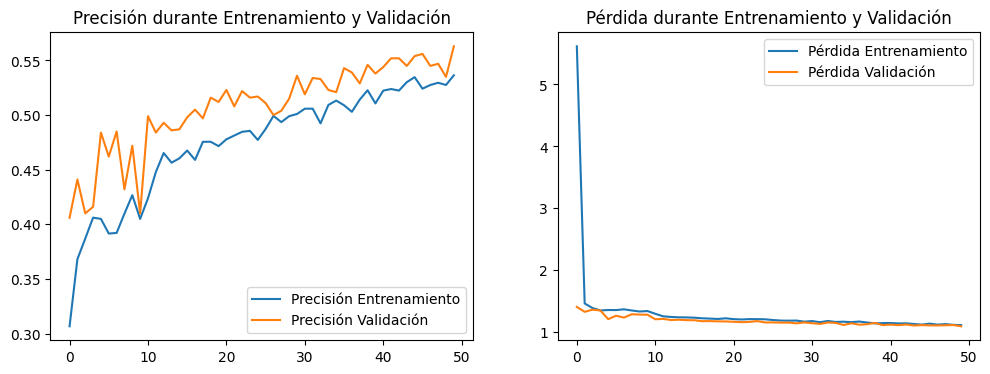

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step


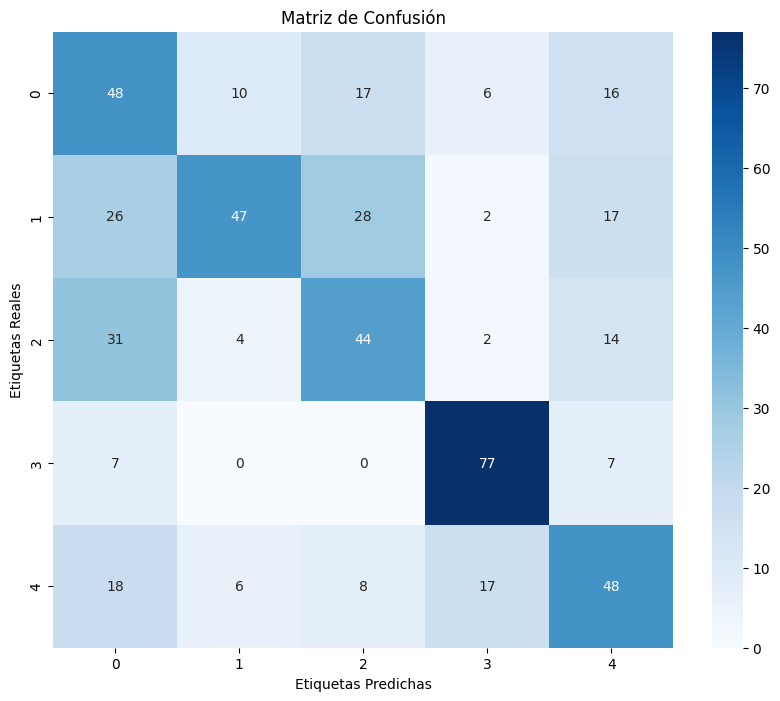

              precision    recall  f1-score   support

   Sunflower       0.37      0.49      0.42        97
       Lotus       0.70      0.39      0.50       120
       Tulip       0.45      0.46      0.46        95
       Lilly       0.74      0.85      0.79        91
      Orchid       0.47      0.49      0.48        97

    accuracy                           0.53       500
   macro avg       0.55      0.54      0.53       500
weighted avg       0.55      0.53      0.53       500



In [9]:
# Visualización de la evolución del entrenamiento
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Precisión Entrenamiento')
plt.plot(epochs_range, val_acc, label='Precisión Validación')
plt.legend(loc='lower right')
plt.title('Precisión durante Entrenamiento y Validación')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Pérdida Entrenamiento')
plt.plot(epochs_range, val_loss, label='Pérdida Validación')
plt.legend(loc='upper right')
plt.title('Pérdida durante Entrenamiento y Validación')
plt.show()

# Evaluación en el conjunto de test
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

test_gen.reset()
predictions = model.predict(test_gen, verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_test = test_gen.classes

# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues)
plt.title('Matriz de Confusión')
plt.ylabel('Etiquetas Reales')
plt.xlabel('Etiquetas Predichas')
plt.show()

# Reporte de Clasificación
print(classification_report(y_test, y_pred, target_names=flower_categories))

## 9. Discusión

- **¿Qué pasaría si se aplicara un preprocesamiento (por ejemplo, ecualización del histograma y filtro gausiano) a las imágenes?**  

- **¿Aumentar el número de épocas mejora el rendimiento?**  

- **¿Qué sucede al incrementar la complejidad del modelo (más capas o neuronas)?**  

- **¿Qué impacto tiene eliminar la capa de dropout?**  

Se recomienda experimentar con estas variables para observar y comprender sus efectos en el desempeño del modelo.
